In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import cftime
import datetime
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import dask
%matplotlib inline
#plt.rcParams['figure.figsize'] = [12, 8]
#plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#plt.gcf().autofmt_xdate()

Les matrices SCRIBE sont le produit d'Environnement Canada que l'on veut répliquer à partir des données binaires du Datamart. Le traitement des données GRIB peut se faire en deux étapes, soit celle de la concaténation et celles du calcul au point de grille. Faisons donc ces manipulations avec les fichiers de l'émission 00z du 22 février 2021 (20210222) et pour la variable de la température moyenne (TMP)

In [3]:
os.chdir('/Users/caramelo/Documents/0000_Unu_Engineering/wasabi_cloud_storage/gem/GDPS/TMP/')
grib_list_total=sorted(glob.glob('*0312_*.grib2'))
grib_list=grib_list_total[0:7]
grib_list

['CMC_glb_TMP_TGL_2_latlon.24x.24_2021030312_P000.grib2',
 'CMC_glb_TMP_TGL_2_latlon.24x.24_2021030312_P003.grib2',
 'CMC_glb_TMP_TGL_2_latlon.24x.24_2021030312_P006.grib2',
 'CMC_glb_TMP_TGL_2_latlon.24x.24_2021030312_P009.grib2',
 'CMC_glb_TMP_TGL_2_latlon.24x.24_2021030312_P012.grib2',
 'CMC_glb_TMP_TGL_2_latlon.24x.24_2021030312_P015.grib2',
 'CMC_glb_TMP_TGL_2_latlon.24x.24_2021030312_P018.grib2']

In [4]:
ds_test=xr.open_dataset(grib_list[0],engine='cfgrib')
ds_test

<xarray.Dataset>
Dimensions:            (latitude: 751, longitude: 1500)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  int64 ...
  * latitude           (latitude) float64 -90.0 -89.76 -89.52 ... 89.76 90.0
  * longitude          (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time         datetime64[ns] ...
Data variables:
    t2m                (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2021-03-23T11:42:00 GRIB to CDM+CF via cfgrib-0....

In [5]:
#ds_test.latitude.values

In [6]:
ds=xr.open_mfdataset(grib_list,concat_dim='valid_time',engine='cfgrib',combine='nested')

In [7]:
ds

<xarray.Dataset>
Dimensions:            (latitude: 751, longitude: 1500, valid_time: 7)
Coordinates:
    time               datetime64[ns] 2021-03-03T12:00:00
    step               (valid_time) timedelta64[ns] 00:00:00 ... 18:00:00
    heightAboveGround  int64 2
  * latitude           (latitude) float64 -90.0 -89.76 -89.52 ... 89.76 90.0
  * longitude          (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
  * valid_time         (valid_time) datetime64[ns] 2021-03-03T12:00:00 ... 20...
Data variables:
    t2m                (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 751, 1500), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2021-03-23T11:42:04 GRIB to CDM+CF via cfgrib-0....

In [8]:
# Convert to celsius
ds=ds-273.15 #passage en celsius
t2m = ds.t2m 

# copy attributes to get nice figure labels and change Kelvin to Celsius
t2m.attrs = ds.t2m.attrs

t2m.attrs["units"] = "deg C"

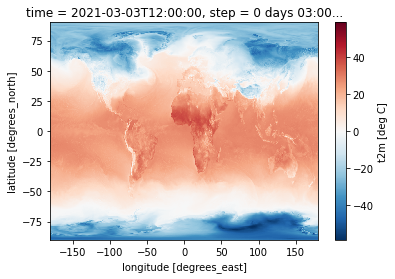

In [9]:
t2m.isel(valid_time=1).plot()

Les fichiers grib d'environnement canada couvrent tout la planète. Je vais donc procèder à circonscrire exclusivement la zone du Québec.

In [10]:
min_lon=-90
min_lat=40
max_lon=-55
max_lat=75

mask_lon= (ds.longitude >=min_lon) & (ds.longitude <=max_lon)
mask_lat= (ds.latitude >=min_lat) & (ds.latitude <=max_lat)

cropped_ds = ds.where(mask_lon & mask_lat, drop=True)
cropped_ds

<xarray.Dataset>
Dimensions:            (latitude: 146, longitude: 146, valid_time: 7)
Coordinates:
    time               datetime64[ns] 2021-03-03T12:00:00
    step               (valid_time) timedelta64[ns] 00:00:00 ... 18:00:00
    heightAboveGround  int64 2
  * latitude           (latitude) float64 40.08 40.32 40.56 ... 74.4 74.64 74.88
  * longitude          (longitude) float64 -90.0 -89.76 -89.52 ... -55.44 -55.2
  * valid_time         (valid_time) datetime64[ns] 2021-03-03T12:00:00 ... 20...
Data variables:
    t2m                (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 146, 146), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal 
    history:                 2021-03-23T11:42:04 GRIB to CDM+CF via cfgrib-0....

<AxesSubplot:title={'center':'time = 2021-03-03T12:00:00, step = 0 days 03:00...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

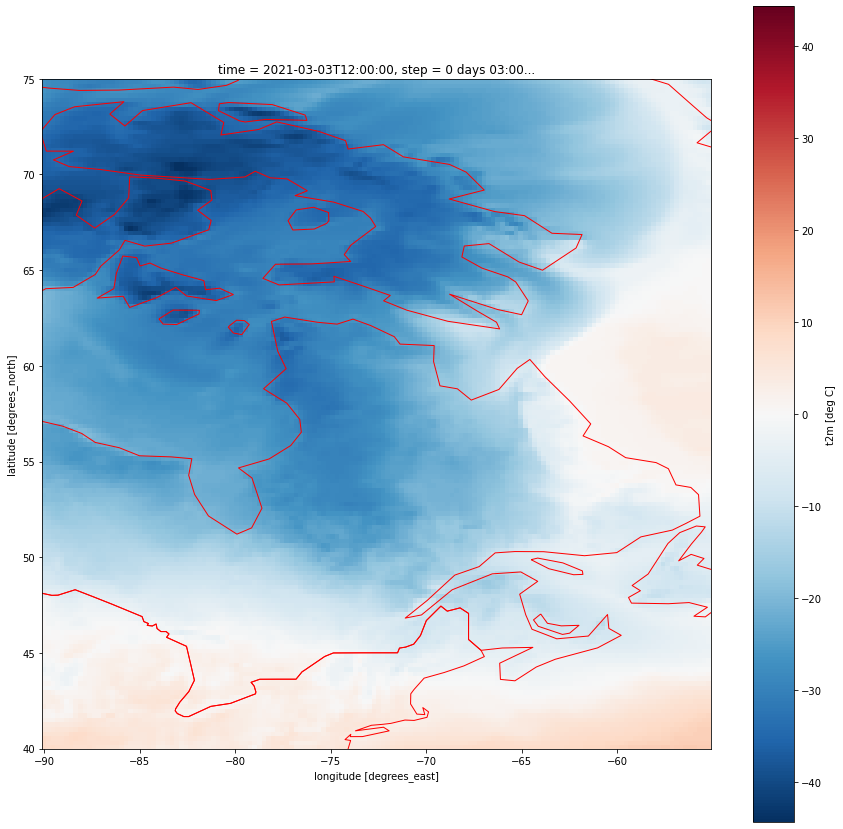

In [11]:
fig,ax=plt.subplots(figsize=(15,15))

countries=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cropped_ds.t2m.isel(valid_time=1).plot(ax=ax)
countries.plot(ax=ax,facecolor='none',edgecolor='red')

Ajout de la carte du canada ainsi que des lignes de transport dans la carte

Liste des stations météorologiques d'interêt

In [13]:
os.chdir('/Users/caramelo/Documents/GitHub/cmc/')


coords_stations=pd.read_csv('Stations matrice scribe.csv')
coords_stations

,OACI,NOMSTN,LAT,LON
0,CYUL,MONTREAL (DORVAL),45.4667,-73.7500
1,CYOW,OTTAWA,45.3167,-75.6667
2,CYVO,VAL D'OR,48.0500,-77.7833
3,CYSC,SHERBROOKE,45.4333,-71.6833
4,CYQB,QUEBEC,46.8000,-71.4000
5,CYRJ,ROBERVAL,48.5167,-72.2667
6,CYGL,LA GRANDE RIVIERE,53.6333,-77.7000
7,CYBC,BAIE COMEAU,49.1333,-68.2000
8,CYZV,SEPT-ILES,50.2167,-66.2500
9,CYRQ,TROIS-RIVIÈRES (A),46.3539,-72.6792


In [14]:
coords_stations.iloc[0,:]

OACI                   CYUL
NOMSTN    MONTREAL (DORVAL)
LAT                 45.4667
LON                  -73.75
Name: 0, dtype: object

In [15]:
#admettons pour la station de montreal 
t2m1d = t2m.sel(latitude=coords_stations.iloc[0,2], longitude=coords_stations.iloc[0,3],method='nearest')
t2m1d

<xarray.DataArray 't2m' (valid_time: 7)>
dask.array<getitem, shape=(7,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    time               datetime64[ns] 2021-03-03T12:00:00
    step               (valid_time) timedelta64[ns] 00:00:00 ... 18:00:00
    heightAboveGround  int64 2
    latitude           float64 45.36
    longitude          float64 -73.68
  * valid_time         (valid_time) datetime64[ns] 2021-03-03T12:00:00 ... 20...
Attributes:
    units:    deg C

Text(0.5, 1.0, 'MONTREAL (DORVAL)')

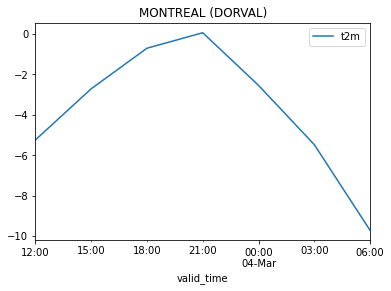

In [16]:
df = t2m1d.reset_coords(drop=True).to_dataframe()
df.plot()
plt.title(coords_stations.iloc[0,1])

Text(0.5, 1.0, 'SHERBROOKE')

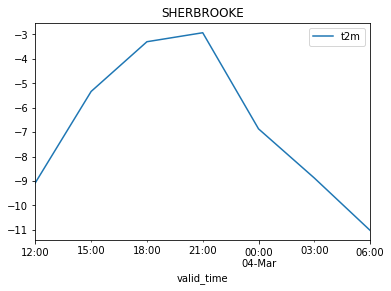

In [17]:
#bon maintenant admettons pour la station de sherbrooke
t2m1d = t2m.sel(latitude=coords_stations.iloc[3,2], longitude=coords_stations.iloc[3,3],method='nearest')
df = t2m1d.reset_coords(drop=True).to_dataframe()
df.plot()
plt.title(coords_stations.iloc[3,1])

Text(0.5, 1.0, 'ROBERVAL')

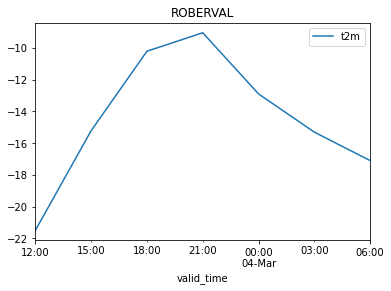

In [18]:
#bon maintenant vu que la température ne change pas trop, allons voir une station bien au nord...Roberval
t2m1d = t2m.sel(latitude=coords_stations.iloc[5,2], longitude=coords_stations.iloc[5,3],method='nearest')
df = t2m1d.reset_coords(drop=True).to_dataframe()
df.plot()
plt.title(coords_stations.iloc[5,1])

Prochaine étape: Vérifier avec la Matrice SCRIBE officielle si les valeur balancent...ajouter l'observation en arrière serait une belle addition aussi!